In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.MStorch import MultiSlice, LARBED
from src.util import toCPU, toGPU, device, SimulationCell
import torch.nn.functional as F


using cuda:0
using torch.float32


In [2]:
si_pg = np.fromfile(r'test\Si\Si110_20x14x1.img', dtype=np.complex64, offset=8).reshape(-1,1024,1024)#[:,256:768,256:768]
simCell = SimulationCell(1024, 1024, 108.6000, 107.5088, 90.0000)

In [3]:
# probe = np.fromfile('test\Si\probe.img', dtype=np.complex64, offset=8).reshape(1024,1024)
# # probe = np.roll(probe, (0,19), axis=(0,1))


# probe = toGPU(probe)
# probe = F.interpolate(probe, size=(512,512), mode='bilinear')
probe = torch.ones((1024,1024), dtype=torch.complex64, device=device)


In [4]:
simulator = MultiSlice(simCell, zStep=7.6792/4, nSlice=200, kV=300, potential=toGPU(si_pg), tilt=(0,0)).to(device)

c:\Users\hcni2\.conda\envs\torch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
dp = simulator.forward(probe)
dp_cpu = toCPU(dp)

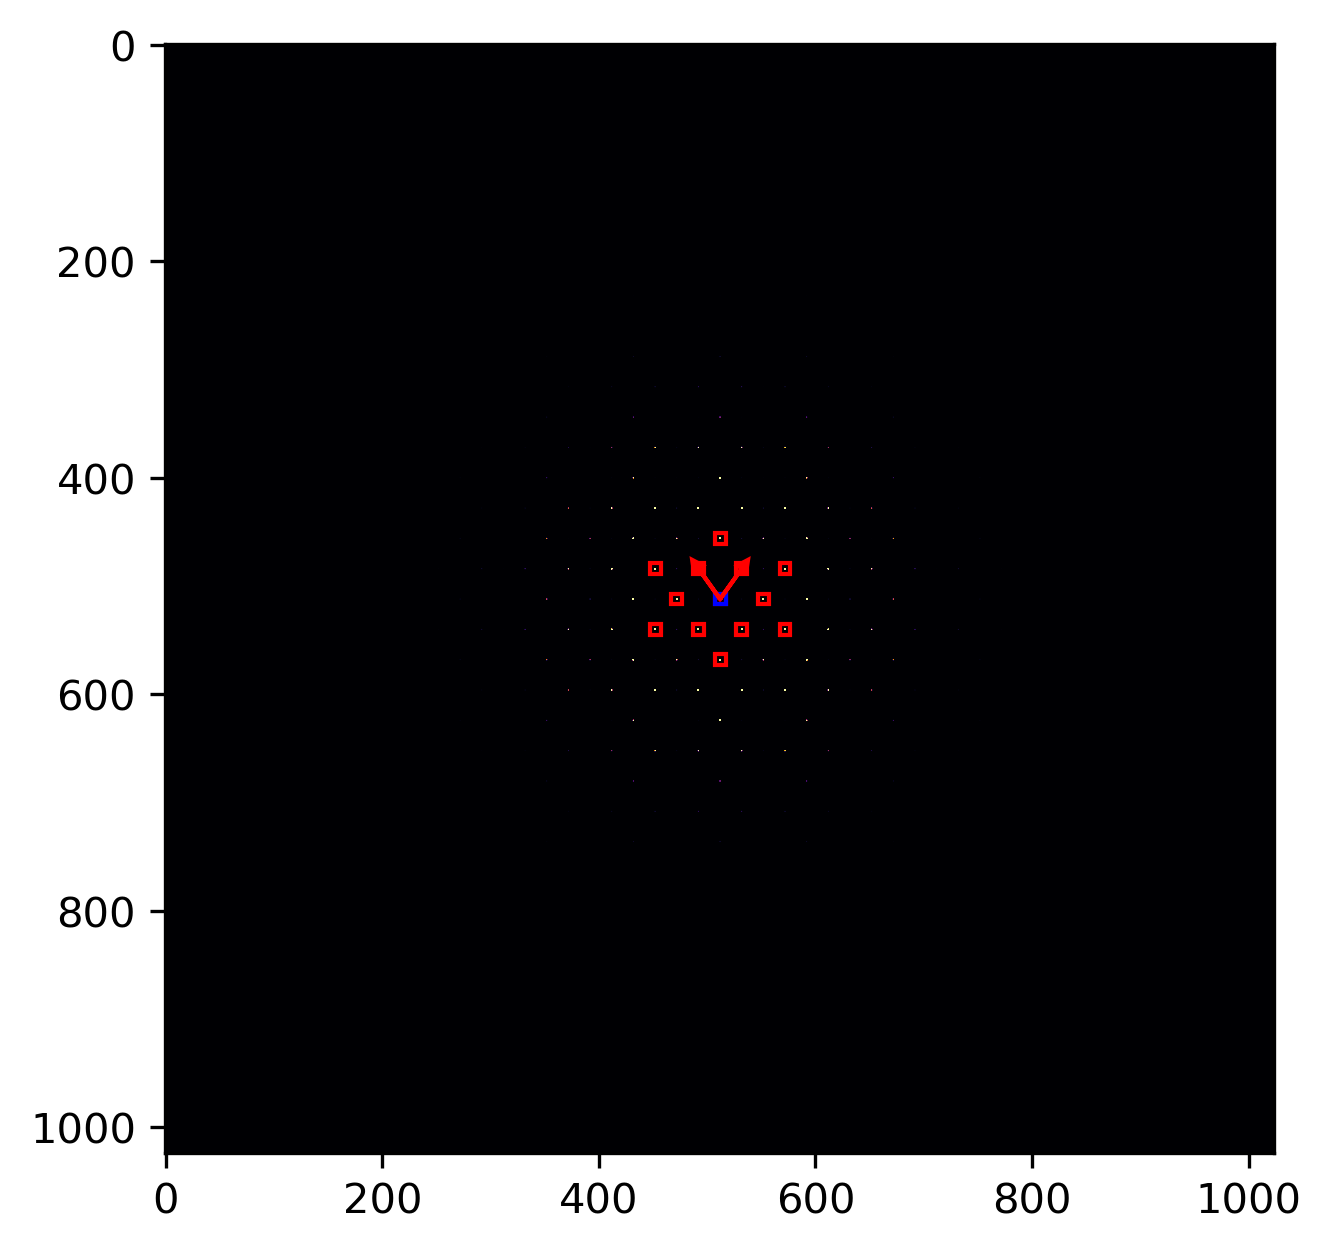

In [6]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(dp_cpu.flatten(), height=1e10)
peak_coords = np.unravel_index(peaks, dp_cpu.shape)
plt.figure(dpi=300)
plt.imshow(dp_cpu, cmap='inferno', vmax=1e8)
# rec = Rectangle((251,251), 5, 5, edgecolor='r', facecolor='none')
# plt.gca().add_patch(rec)
# plt.colorbar()

# Mark peaks using a rectangle patch
for i in range(len(peak_coords[0])):
    rec = Rectangle((peak_coords[1][i]-5,peak_coords[0][i]-5), 10, 10, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rec)

# find the peak cloest to the center
center = np.array(dp_cpu.shape)//2
dist = np.sum((np.array(peak_coords).T - center)**2, axis=1)
min_idx = np.argmin(dist)
rec = Rectangle((peak_coords[1][min_idx]-5,peak_coords[0][min_idx]-5), 10, 10, edgecolor='b', facecolor='none')
plt.gca().add_patch(rec)

# calculate the distance between the center peak and other peaks
dist = np.sqrt(np.sum((np.array(peak_coords).T - np.array(peak_coords).T[min_idx])**2, axis=1))
# find the two closest peaks and plot arrow from  center peak to the two closest peaks
min_idx = np.argsort(dist)[1:3]
vector = []
for i in min_idx:
    plt.arrow(center[1], center[0], peak_coords[1][i]-center[1], peak_coords[0][i]-center[0], head_width=10, head_length=10, fc='r', ec='r')
    vector.append([peak_coords[1][i]-center[1], peak_coords[0][i]-center[0]])









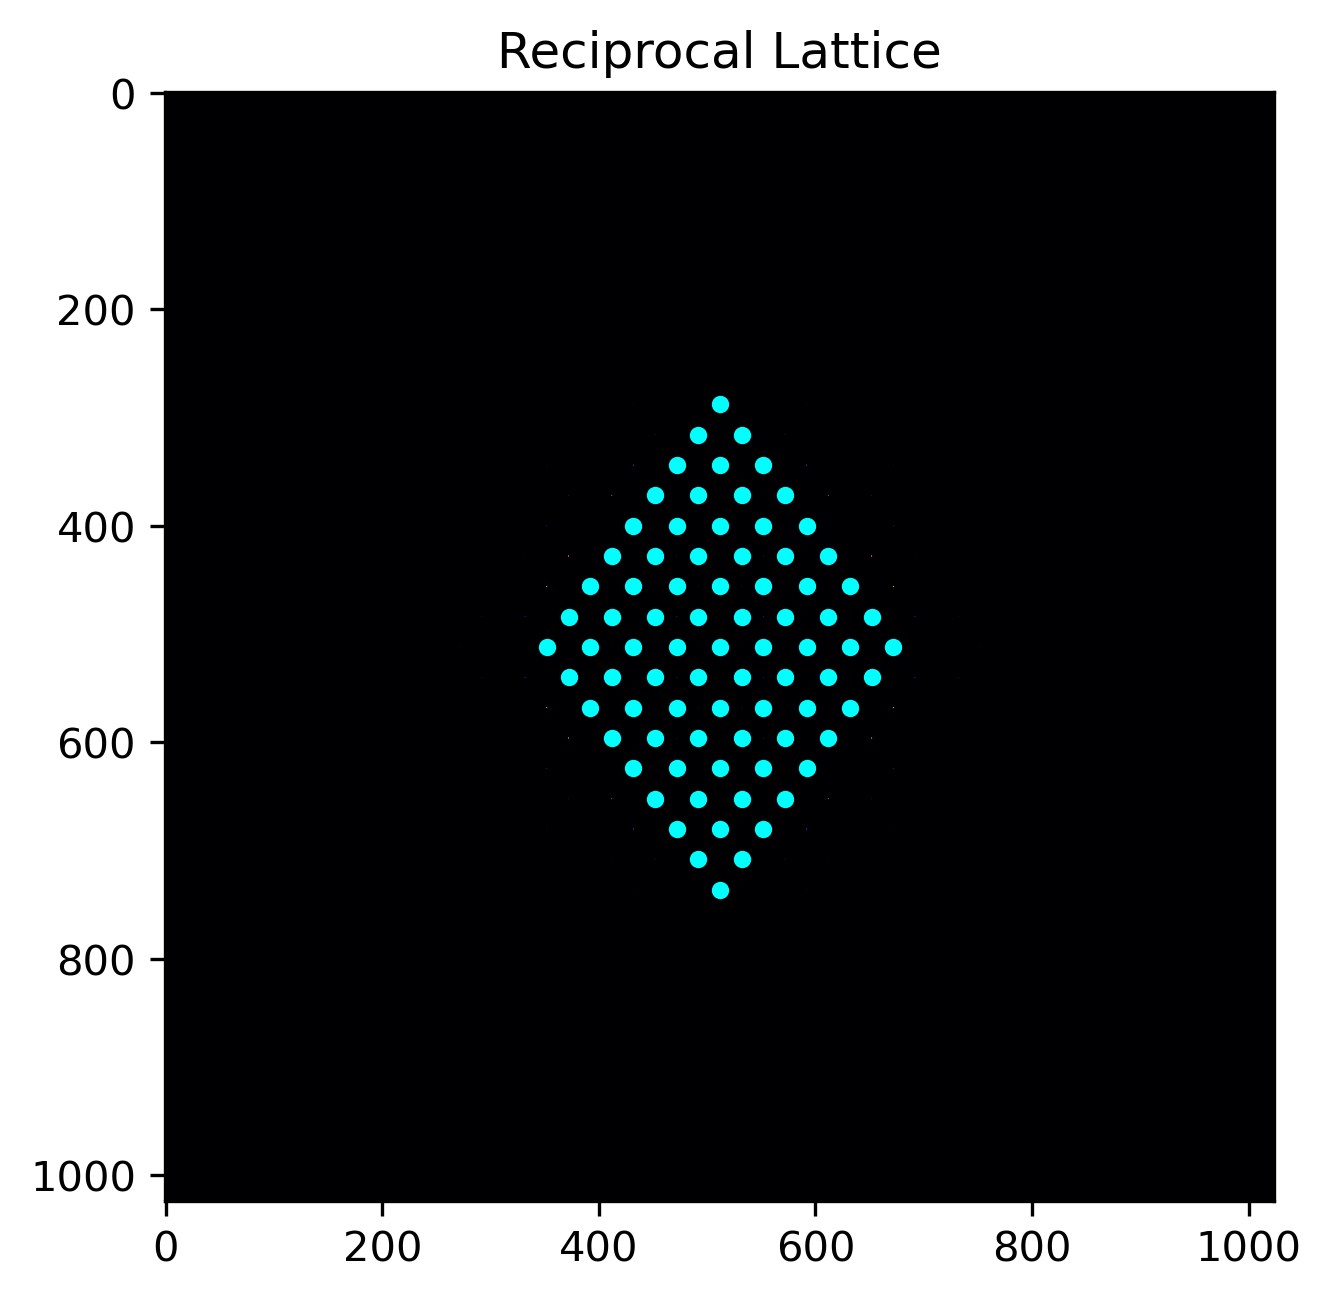

In [7]:
# Extract the two vectors
vector1 = np.array([peak_coords[0][min_idx[0]] - center[0], peak_coords[1][min_idx[0]] - center[1]])
vector2 = np.array([peak_coords[0][min_idx[1]] - center[0], peak_coords[1][min_idx[1]] - center[1]])

# Create a grid of points using the two vectors
grid_points = []
for i in range(-4, 5):
    for j in range(-4, 5):
        point = i * vector1 + j * vector2
        grid_points.append(point)

grid_points = np.array(grid_points)

# Plot the reciprocal lattice
plt.figure(dpi=300)
plt.imshow(dp_cpu, cmap='inferno', vmax=1e8)
plt.scatter(grid_points[:, 1] + center[1], grid_points[:, 0] + center[0], color='cyan', s=10)
plt.title('Reciprocal Lattice')
plt.show()

In [8]:
zmult = np.fromfile(r'C:\Users\hcni2\Box\ZuoLab\active dopant\zmult\ms\Si110_20x14x1_conv9_def0_Si.im3', offset=8, dtype=np.float32).reshape(1024,1024)[256:768,256:768]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

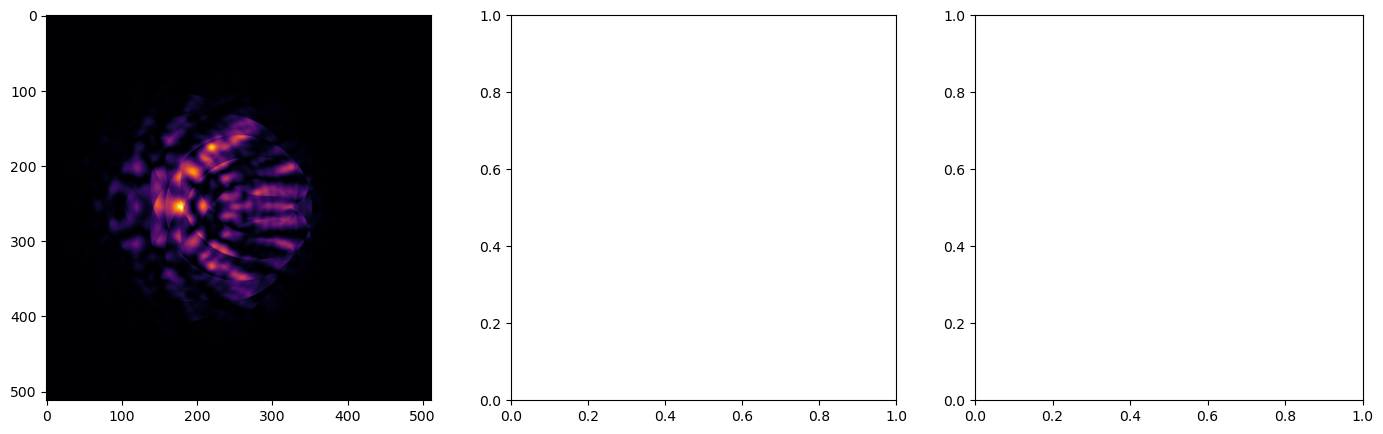

In [9]:

fig, axes = plt.subplots(1,3, figsize=(17,5)) 
# plt.imshow(zmult, cmap='inferno')
# plt.colorbar()
im1 = axes[0].imshow(zmult, cmap='inferno')
im2 = axes[1].imshow(dp, cmap='inferno')
im3 = axes[2].imshow(zmult - dp, cmap='inferno')
# add colorbar for each axes
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im1, cax=cax1)

divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im2, cax=cax2)

divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im3, cax=cax3)


In [3]:
probe = torch.ones((1024,1024), dtype=torch.complex64, device=device)

In [4]:
x,y = np.mgrid[-3:2, -3:2]
beams = np.vstack((x.flatten(), y.flatten())).T
larbed = LARBED(simCell, zStep=7.6792/4, nSlice=200, kV=300, nTilt=15, tiltStep=8, potential=toGPU(si_pg), tilt=(0,0), beams=beams).to(device)

c:\Users\hcni2\.conda\envs\torch\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
with torch.no_grad():
    sim = larbed(probe)
print(torch.cuda.memory.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1616 MB |    1656 MB |    9079 GB |    9077 GB |
|       from large pool |    1616 MB |    1656 MB |    9078 GB |    9077 GB |
|       from small pool |       0 MB |       1 MB |       0 GB |       0 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1616 MB |    1656 MB |    9079 GB |    9077 GB |
|       from large pool |    1616 MB |    1656 MB |    9078 GB |

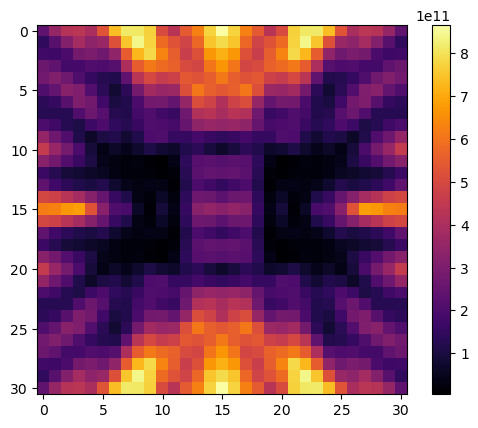

In [6]:
plt.imshow(toCPU(sim), cmap='inferno')
plt.colorbar()

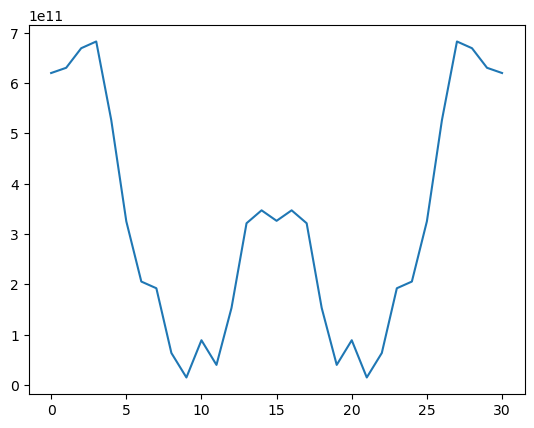

In [7]:
plt.plot(toCPU(sim)[15])

In [14]:
from math import sin
x = torch.linspace(-simCell.cellx / 2, simCell.cellx / 2, simCell.nx)

y = torch.linspace(-simCell.celly / 2, simCell.celly / 2, simCell.nx)
X, Y = torch.meshgrid(x, y)
tilted = torch.exp(-2j*torch.pi*(X*simCell.reciprocalx*20+Y*simCell.reciprocaly*0))
tilted = tilted/torch.abs(tilted)

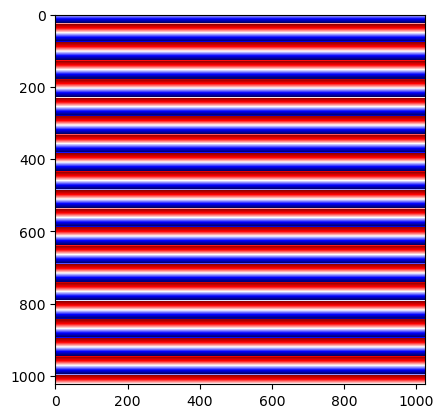

In [15]:
plt.imshow(np.angle(toCPU(tilted)), cmap='seismic', vmin=-np.pi, vmax=np.pi)

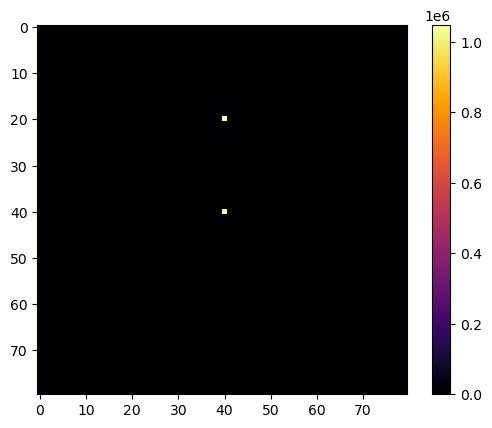

In [17]:
intensity = np.abs(toCPU(torch.fft.fftshift(torch.fft.fft2(tilted))))[512-40:512+40,512-40:512+40]
intensity[40,40] = np.max(intensity)
plt.imshow(intensity, cmap='inferno')
plt.colorbar()
